In [1]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2 as cv
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [3]:
pickle_in = open("x_train","rb")
x_train = pickle.load(pickle_in)

pickle_in = open("x_val","rb")
x_val = pickle.load(pickle_in)

pickle_in = open("y_train","rb")
y_train = pickle.load(pickle_in)

pickle_in = open("y_val","rb")
y_val = pickle.load(pickle_in)

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(38400, 150, 150, 3)
(38400,)
(9600, 150, 150, 3)
(9600,)


In [5]:
path = "data"
mylist = os.listdir(path)
print(mylist)
noofclasses = (len(mylist))
noofclasses    

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


10

In [6]:
# check the quantity of training data of each class.
numofSamples= []
for x in range(0, noofclasses):
    numofSamples.append(len(np.where(y_train==x)[0]))
print(numofSamples)

[3750, 4344, 3808, 3892, 3755, 3473, 3785, 4023, 3780, 3790]


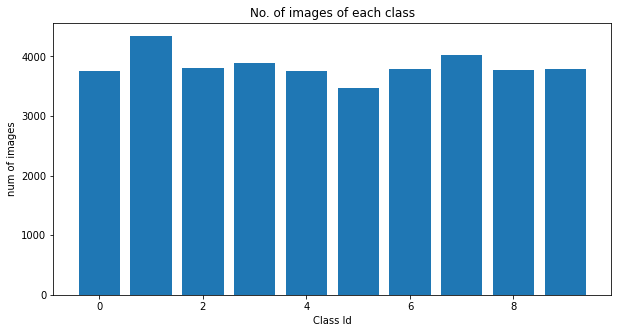

In [7]:
#create barchat of visualize the upper data.
plt.figure(figsize = (10,5))
plt.bar(range(0, noofclasses),numofSamples)
plt.title("No. of images of each class")
plt.xlabel("Class Id")
plt.ylabel("num of images")
plt.show()

In [8]:
y_train[30]

8

In [9]:
# before preprocessing
print(x_train[30].shape)

(150, 150, 3)


In [10]:
# preprocessing

def preprocessing(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.equalizeHist(img)
    img = img/255
    return img

In [ ]:
#mapping

x_train = np.array(list(map(preprocessing,x_train)))
x_val = np.array(list(map(preprocessing,x_val)))

In [ ]:
#after preprocessing
print(x_train[30].shape)

(150, 150)


In [13]:
#before the reshape
print(x_train.shape)
print(x_val.shape)

(38400, 150, 150)
(9600, 150, 150)


In [14]:
# create deapth of images for CNN algo.
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)

In [15]:
#after the reshape
print(x_train.shape)
print(x_val.shape)

(38400, 150, 150, 1)
(9600, 150, 150, 1)


In [8]:
# data augmentation

datagen = ImageDataGenerator(width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range= 0.2,
    shear_range=0.1,
    rotation_range =10)   



In [9]:
datagen.fit(x_train)

NameError: name 'x_train' is not defined

In [18]:
y_train = to_categorical(y_train,noofclasses)
y_val = to_categorical(y_val,noofclasses)

In [19]:
# model building

def mymodel():
    nooffilters = 60
    sizeoffilter1 = (5,5)
    sizeoffilter2 = (3,3)
    sizeofPool = (2,2)
    noofNode = 500
    
    model = Sequential()
    
    model.add(Conv2D(nooffilters,sizeoffilter1,input_shape =(150,150,1),activation = "relu"))
    model.add(Conv2D(nooffilters,sizeoffilter1,activation = "relu",padding = "same"))
    model.add(MaxPooling2D(pool_size = sizeofPool))
    
    model.add(Conv2D(nooffilters//2,sizeoffilter2,activation = "relu"))
    model.add(Conv2D(nooffilters//2,sizeoffilter2,activation = "relu"))
    model.add(MaxPooling2D(pool_size = sizeofPool))
    
    model.add(Conv2D(15,sizeoffilter2,activation = "relu"))
    model.add(MaxPooling2D(pool_size = sizeofPool))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(noofNode,activation = "relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(noofclasses,activation = "softmax"))
    
    model.compile(optimizer = "adam",loss = "categorical_crossentropy",metrics=["accuracy"])
    return model
    

In [20]:
model = mymodel()

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 60)      1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 60)      90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 30)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 15)        4

In [22]:
from keras.callbacks import ModelCheckpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True,save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

In [23]:
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size= 50),
                              epochs = 10,
                              validation_data = (x_val, y_val),
                              shuffle = 1,callbacks = callbacks_list)

c:\users\vaibh\miniconda3\envs\cv\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
768/768 [==============================] - 670s 606ms/step - loss: 1.1105 - accuracy: 0.6187 - val_loss: 0.0985 - val_accuracy: 0.9716

Epoch 00001: accuracy improved from -inf to 0.77924, saving model to best_model.hdf5
Epoch 2/10
768/768 [==============================] - 691s 900ms/step - loss: 0.2801 - accuracy: 0.9139 - val_loss: 0.0665 - val_accuracy: 0.9786

Epoch 00002: accuracy improved from 0.77924 to 0.92026, saving model to best_model.hdf5
Epoch 3/10
768/768 [==============================] - 306s 397ms/step - loss: 0.2116 - accuracy: 0.9348 - val_loss: 0.0488 - val_accuracy: 0.9857

Epoch 00003: accuracy improved from 0.92026 to 0.93953, saving model to best_model.hdf5
Epoch 4/10
768/768 [==============================] - 300s 390ms/step - loss: 0.1701 - accuracy: 0.9497 - val_loss: 0.0474 - val_accuracy: 0.9870

Epoch 00004: accuracy improved from 0.93953 to 0.95070, saving model to best_model.hdf5
Epoch 5/10
768/768 [==============================] - 292s 380m

In [24]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

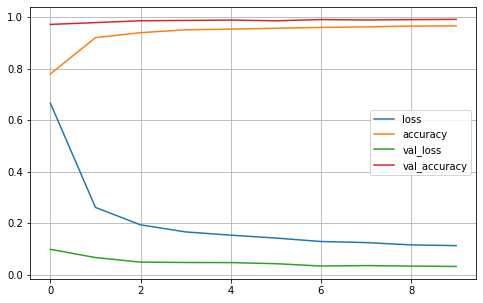

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [11]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
new_model = model_from_json(loaded_model_json)
# load weights into new model
new_model.load_weights("best_model.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 60)      1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 60)      90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 30)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 15)        4

# testing

In [3]:
pickle_in = open("x_test","rb")
x_test = pickle.load(pickle_in)

pickle_in = open("y_test","rb")
y_test = pickle.load(pickle_in)

In [4]:
def preprocessing(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.equalizeHist(img)
    img = img/255
    return img

In [ ]:
x_test = np.array(list(map(preprocessing,x_test)))

In [ ]:
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

In [ ]:
y_test = to_categorical(y_test,10)

In [8]:
print(x_test.shape)

(12000, 150, 150, 1)


In [9]:
print(y_test.shape)

(12000, 10)


In [13]:
new_model.compile(optimizer = "adam",loss = "categorical_crossentropy",metrics=["accuracy"])

In [14]:
score = new_model.evaluate(x_test,y_test,verbose=0)


In [15]:
print("Test score: ", score[0])

Test score:  0.03423945978283882


In [16]:
print("Test accuracy: ", score[1])

Test accuracy:  0.9890833497047424


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [25]:
pred_y = new_model.predict_classes(x_test)

c:\users\vaibh\miniconda3\envs\cv\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [22]:
y_test.counts()

AttributeError: 'numpy.ndarray' object has no attribute 'counts'

In [26]:
ac = confusion_matrix(y_test,y_test)
ac

ValueError: multilabel-indicator is not supported

In [27]:
cm= confusion_matrix(pred_y,y_test)
cm

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['0','1',"2",'3','4'.'5','6','7','8','9']


plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')